In [1]:
from __future__ import division
import os, warnings, tensorflow as tf
from utils import *

In [2]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Load datasets

In [3]:
from dsl.fashionmnist_dsl import FashionMNISTDSL

### Partition classes

In [4]:
partition_seed = 1337

np.random.seed(partition_seed)

train_dsl = FashionMNISTDSL(batch_size=100, mode='test', normalize_channels=False, shuffle_each_epoch=False, seed=666)
chosen_classes = list(np.random.choice(np.arange(train_dsl.num_classes), train_dsl.num_classes//2, False))
remaining_classes = list(set(list(np.arange(train_dsl.num_classes))) - set(chosen_classes))

Loading test data
datasets/fashionmnist/t10k-images-idx3-ubyte
(10000, 28, 28, 1)
(10000,)


In [5]:
chosen_classes

[6, 3, 0, 4, 5]

In [6]:
remaining_classes

[8, 1, 2, 9, 7]

### Load confidential dataset $\mathcal{D}_C$

In [7]:
train_dsl = FashionMNISTDSL(batch_size = 100, mode='train', normalize_channels=False, shuffle_each_epoch=False, seed=666, keep_class=chosen_classes)
val_dsl   = FashionMNISTDSL(batch_size = 100, mode='val', normalize_channels=False, shuffle_each_epoch=False, seed=666, keep_class=chosen_classes)

Creating DSL only for classes 6 3 0 4 5
Loading train data
datasets/fashionmnist/train-images-idx3-ubyte
(60000, 28, 28, 1)
(60000,)
processing...


Creating DSL only for classes 6 3 0 4 5
Loading val data
datasets/fashionmnist/train-images-idx3-ubyte
(60000, 28, 28, 1)
(60000,)
processing...


### Load benign users

In [9]:
PD_test_dsl  = FashionMNISTDSL(batch_size = 100, mode='test', normalize_channels=False, shuffle_each_epoch=False, seed=666, keep_class=chosen_classes)

Creating DSL only for classes 6 3 0 4 5
Loading test data
datasets/fashionmnist/t10k-images-idx3-ubyte
(10000, 28, 28, 1)
(10000,)
processing...


In [10]:
np.unique(PD_test_dsl.labels)

array([0, 3, 4, 5, 6], dtype=int32)

In [11]:
PD_test_dsl.data.shape

(5000, 28, 28, 1)

In [12]:
AltPD_test_dsl  = FashionMNISTDSL(batch_size = 100, mode='test', normalize_channels=False, shuffle_each_epoch=False, seed=666, keep_class=remaining_classes)

Creating DSL only for classes 8 1 2 9 7
Loading test data
datasets/fashionmnist/t10k-images-idx3-ubyte
(10000, 28, 28, 1)
(10000,)
processing...


In [13]:
np.unique(AltPD_test_dsl.labels)

array([1, 2, 7, 8, 9], dtype=int32)

In [14]:
PD_test_dsl.data.shape

(5000, 28, 28, 1)

### Obtain dataset parameters

In [15]:
width, height, channels = train_dsl.get_sample_shape()

is_multilabel = train_dsl.is_multilabel()
num_classes = train_dsl.get_num_classes()
num_batches = train_dsl.get_num_batches()

### Load attacker datasets $\mathcal{D}_A$

Syn-Uniform Retraining (Tramer _et al._ [1])

In [16]:
from dsl.uniform_dsl import UniformDSL

sample_shape = (width, height, channels)
uniform_dsl = UniformDSL(batch_size=100, mode='train', shape=sample_shape, sample_limit=1000, seed=666)

ImageNet samples

In [17]:
from dsl.imagenet_dsl import ImagenetDSL

resize = (width, height)
img_noise_train_dsl = ImagenetDSL(batch_size=100, mode='train', resize=resize, normalize_channels=True, num_to_keep=1000, start_batch=1, end_batch=1, seed=666)

Loading train data
datasets/Imagenet64/train_data_batch_1.npy


## Create models

In [18]:
import tensorflow as tf
from models.deepcnn import DeepCNN
from models.vae import NewHSVNVAE

TensorFlow version 1.14.0 has been patched using tfdeterminism version 0.3.0
TensorFlow version 1.14.0 has been patched using tfdeterminism version 0.3.0


In [19]:
from cfg import cfg, config

In [ ]:
with tf.variable_scope("vae", reuse=tf.AUTO_REUSE):
    vae = NewHSVNVAE(
            batch_size=cfg.batch_size,
            height=height, width=width,
            channels=channels,
            num_classes=2,
            is_training=False,
            z_size=32,
            random_draws=1,
            noise_mean=5.0
         )

In [21]:
saver = tf.train.Saver()

In [22]:
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [23]:
saver.restore(sess, 'modeldir/fashionmnist-1337/model_epoch_100')

INFO:tensorflow:Restoring parameters from modeldir/fashionmnist-1337/model_epoch_100


INFO:tensorflow:Restoring parameters from modeldir/fashionmnist-1337/model_epoch_100


## Load AdvPD samples

In [24]:
import copy

In [25]:
advpd_dsl = copy.deepcopy(train_dsl)
advpd_dsl.data = np.load('datasets/AdvPD.npy')

## Draw latents

In [26]:
true_train_zs = sample_z(vae, train_dsl, sess)
true_val_zs = sample_z(vae, val_dsl, sess)
uniform_zs    = sample_z(vae, uniform_dsl, sess)
advpd_zs      = sample_z(vae, advpd_dsl, sess)
img_noise_zs  = sample_z(vae, img_noise_train_dsl, sess)

In [27]:
pd_zs = sample_z(vae, PD_test_dsl, sess)
altpd_zs = sample_z(vae, AltPD_test_dsl, sess)

## MMD Computation

In [28]:
def base_kernel(x, y, sigma):
    norm_square = np.linalg.norm(x-y) ** 2
    sigma_square = sigma ** 2
    
    return np.exp(- norm_square /(2* sigma_square))

def composite_kernel(x, y, sigmas):
    result = 0
    
    for sigma in sigmas:
        result += base_kernel(x, y, sigma)
        
    return result

def compute_mmd(dataset_x, dataset_y, sigmas=[1, 5, 10, 15, 20]):
    result = 0
    
    n = len(dataset_x)
    m = len(dataset_y)
    
    for i in range(n):
        for j in range(n):
            result += 1./(n**2) * composite_kernel(dataset_x[i], dataset_x[j], sigmas)
    
    for i in range(n):
        for j in range(m):
            result -= 2./(n*m) * composite_kernel(dataset_x[i], dataset_y[j], sigmas)
    
    for i in range(m):
        for j in range(m):
            result += 1./(m**2) * composite_kernel(dataset_y[i], dataset_y[j], sigmas)
            
    return np.sqrt(result)

In [29]:
draws = 20
samples_per_draw = 100

for _ in range(draws):
    train_subs = true_train_zs[np.random.choice(true_train_zs.shape[0], samples_per_draw, replace=False)]

In [30]:
def test_mmd(train, val, test, draws=20):
    res = compute_mmd(train_subs, test)
    return res

In [31]:
from multiprocessing import Pool

### PD Samples

In [35]:
def test_mmd_wrapper(i):
    return test_mmd(true_train_zs, true_val_zs, pd_zs[i+100:i+200])

p = Pool(20)
test_mmds = p.map(test_mmd_wrapper, [i for i in range(250)])
p.close()
p.join()

### AltPD Samples

In [36]:
def test_mmd_wrapper(i):
    return test_mmd(true_train_zs, true_val_zs, altpd_zs[i+100:i+200])

p = Pool(20)
altpd_test_mmds = p.map(test_mmd_wrapper, [i for i in range(250)])
p.close()
p.join()

### Syn Attacker

In [37]:
def unif_mmd_wrapper(i):
    return test_mmd(true_train_zs, true_val_zs, uniform_zs[i+100:i+200])

p = Pool(20)
unif_mmds = p.map(unif_mmd_wrapper, [i for i in range(250)])
p.close()
p.join()

### AdvPD Attacker

In [38]:
def pap_mmd_wrapper(i):
    return test_mmd(true_train_zs, true_val_zs, advpd_zs[i+100:i+200])

p = Pool(20)
pap_mmds = p.map(pap_mmd_wrapper, [i for i in range(250)])
p.close()
p.join()

### NPD Attacker

In [39]:
def img_mmd_wrapper(i):
    return test_mmd(true_train_zs, true_val_zs, img_noise_zs[i+100:i+200])

p = Pool(20)
img_mmds = p.map(img_mmd_wrapper, [i for i in range(250)])
p.close()
p.join()

### Plot Results

#### Against PD Benign User only

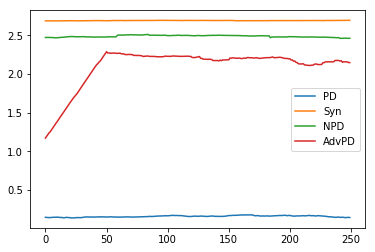

In [40]:
p1 = plt.plot(test_mmds)
p2 = plt.plot(unif_mmds)
p3 = plt.plot(img_mmds)
p4 = plt.plot(pap_mmds)

plt.legend((p1[0], p2[0], p3[0], p4[0]), ('PD', 'Syn', 'NPD', 'AdvPD'))

#### Including AltPD Benign User

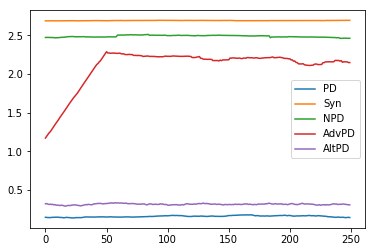

In [41]:
p1 = plt.plot(test_mmds)
p2 = plt.plot(unif_mmds)
p3 = plt.plot(img_mmds)
p4 = plt.plot(pap_mmds)
p5 = plt.plot(altpd_test_mmds)

plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('PD', 'Syn', 'NPD', 'AdvPD', 'AltPD'))